# Project 3 INF264

Author: Johanna Jøsang (fak006)

In [58]:
# Imports
import numpy as np
import collections
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import random
import timeit
from pprint import pprint
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# LeNet-5 imports
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import np_utils

In [2]:
# Set seed for project in order to replicate results
seed = 123

In [3]:
# Load data
label_data = np.genfromtxt('handwritten_digits_labels.csv', delimiter=',')
image_data = np.genfromtxt('handwritten_digits_images.csv', delimiter=',')
image_data = image_data.reshape(image_data.shape[0], 28, 28) # reshaping data

## Visualisation and preprocessing

In order to get a better understanding of the data I have been given, I start by gathering information about it.
First I would like to get a look at the shape of the data.

In [4]:
print("Label data shape:", label_data.shape)
print("Image data shape:", image_data.shape)

Label data shape: (70000,)
Image data shape: (70000, 28, 28)


As expected, the label dataset is a simple array with 70000 values, while the image dataset has 70000 2d arrays represetning the digit image.

Just to visalize the data for myself I print out a random image and its corresponding label.

At index 38831 there is a 5.0


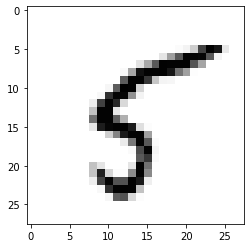

In [5]:
data_index = random.randint(0, label_data.size)
img = image_data[data_index]
plt.imshow(img, cmap="Greys")
print("At index", data_index, "there is a", label_data[data_index])

### Digit distribution

In order to find out how the data is distributed between the 10 digits, I print out the frequency, percentages and a histogram to see the distribution.

In [6]:
# Count number of examples for each digit
label_counter = collections.Counter(label_data)
print(label_counter)

# Print out the percentages for each digit
label_data_size = label_data.size
for i in range(10):
    percentage = (label_counter[i] / label_data_size) * 100
    print(i, ": ", "%.2f" % percentage, "%")
    
# Print min and max, which can easily be count ince label_counter is sorted by frequency
print("Min freq is 5 with", "%.2f" % ((label_counter[5] / label_data_size) * 100), "%")
print("Max freq is 1 with", "%.2f" % ((label_counter[1] / label_data_size) * 100), "%")

Counter({1.0: 7877, 7.0: 7293, 3.0: 7141, 2.0: 6990, 9.0: 6958, 0.0: 6903, 6.0: 6876, 8.0: 6825, 4.0: 6824, 5.0: 6313})
0 :  9.86 %
1 :  11.25 %
2 :  9.99 %
3 :  10.20 %
4 :  9.75 %
5 :  9.02 %
6 :  9.82 %
7 :  10.42 %
8 :  9.75 %
9 :  9.94 %
Min freq is 5 with 9.02 %
Max freq is 1 with 11.25 %


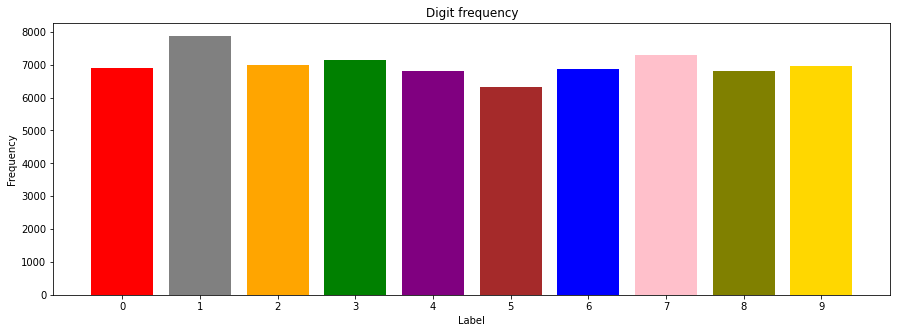

In [7]:
# Histogram
names = list(label_counter.keys())
values = list(label_counter.values())
fig = plt.figure(figsize=(15,5))
plt.bar(names, values, color=['red', 'grey', 'orange', 'green', 'purple', 'brown', 'blue', 'pink', 'olive', 'gold'])
plt.xticks(np.arange(0, 10))
plt.ylabel('Frequency')
plt.xlabel('Label')
plt.title("Digit frequency");

All digits have about 10% of the data, so it does not seem like the dataset needs to be balanced. The least frequent digit was 5 (9.02 %) and the most frequent was 1 (11.25 %). If our trained classifiers become much worse at categorizing 5s compared to 1s then we can perhaps go back and balance the data.

In [8]:
X_train_val, X_test, y_train_val, y_test = train_test_split(image_data, label_data, test_size=0.1, shuffle=True, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=True, random_state=seed)


In [9]:
def reshape_3d_to_2d(data_3d):
    '''
    Reshape 3-dimensional data to 2-dimensional data, by combining the last two dimensions to a multiple of the two.
    '''
    number_of_samples, x_dim, y_dim = data_3d.shape
    dataset_2d = data_3d.reshape((number_of_samples,x_dim*y_dim))
    return dataset_2d

X_train_2d = reshape_3d_to_2d(X_train)
X_val_2d = reshape_3d_to_2d(X_val)
X_train_val_2d = reshape_3d_to_2d(X_train_val)

## Baseline and evaluation methods
Since we are creating classifiers, the evaluation method will be classification accuracy. For a more representative accuracy value, k-fold cross validation will be used, with k = 3. We will be using a simple decision tree classifier as a baseline.

In [10]:
kfold = KFold(n_splits=3) # initialize the kfold splitter with 3 splits

In [11]:
dTree_clf = DecisionTreeClassifier(random_state= seed)
scores = cross_val_score(dTree_clf, X_train_val_2d, y_train_val, cv=3)

In [12]:
print("Cross validation score for decision tree classifier is:", np.mean(scores))

Cross validation score for decision tree classifier is: 0.8635396825396825


## Random forest classifier
The classifier being used is sklearn's Random Forest Classifier: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [13]:
val_acc_at_depth = {} # Dictionary for keeping track of depth vs accuracy
train_acc_at_depth = {} # Dictionary for keeping track of depth vs accuracy
for i in range(1, 20):
    clf = RandomForestClassifier(max_depth = i)
    #cross_val_scores = cross_val_score(clf, X_train_val_2d, y_train_val)
    clf.fit(X_train_2d, y_train)
    train_score = clf.score(X_train_2d, y_train)
    val_score = clf.score(X_val_2d, y_val)
    #mean_cross_val_score = np.mean(cross_val_scores)
    print("Precision at depth", i , "is val:", val_score, "train", train_score)
    #acc_at_depth[i] = mean_cross_val_score 
    train_acc_at_depth[i] = train_score
    val_acc_at_depth[i] = val_score

Precision at depth 1 is val: 0.5428571428571428 train 0.5477777777777778
Precision at depth 2 is val: 0.6096031746031746 train 0.6145039682539682
Precision at depth 3 is val: 0.7346825396825397 train 0.7337896825396826
Precision at depth 4 is val: 0.812063492063492 train 0.814781746031746
Precision at depth 5 is val: 0.8617460317460317 train 0.8671626984126984
Precision at depth 6 is val: 0.8878571428571429 train 0.8945238095238095
Precision at depth 7 is val: 0.9079365079365079 train 0.9172023809523809
Precision at depth 8 is val: 0.9238095238095239 train 0.9354960317460318
Precision at depth 9 is val: 0.9342857142857143 train 0.9518253968253968
Precision at depth 10 is val: 0.9450793650793651 train 0.9675992063492064
Precision at depth 11 is val: 0.9508730158730159 train 0.9793452380952381
Precision at depth 12 is val: 0.9563492063492064 train 0.9883333333333333
Precision at depth 13 is val: 0.9606349206349206 train 0.9935714285714285
Precision at depth 14 is val: 0.962936507936508 t

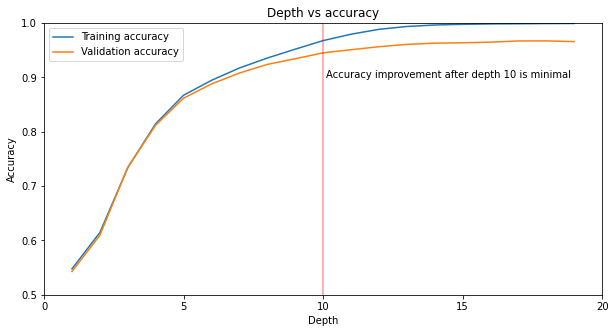

In [75]:
x = train_acc_at_depth.keys()
train_y = train_acc_at_depth.values()
val_y = val_acc_at_depth.values()
fig = plt.figure(figsize=(10,5))
plt.plot(x,train_y, label = "Training accuracy")
plt.plot(x,val_y, label = "Validation accuracy")
plt.legend()
plt.axvline(x=10, ymin=0, ymax=1, color = 'r', alpha = 0.4)
plt.text(10.1, 0.9, "Accuracy improvement after depth 10 is minimal")
plt.ylim(bottom=0.5, top = 1)
plt.title("Depth vs accuracy")
plt.xticks(np.arange(0, 21, 5))
plt.ylabel('Accuracy')
plt.xlabel('Depth')
plt.show()

While the accuracy did seem increase as max_depth was increased, the improvement was so marginal it did not justify the increased runtime. Hence max_depth was simply set to 10.

In [15]:
rf = RandomForestClassifier(random_state = seed)
print('Possible parameters for random forest:')
pprint(rf.get_params())

Possible parameters for random forest:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}


After maually testing out a couple of different hyperparameters to get an idea of how they impacted to accuracy, it became clear that only a small subset of the combinations would be able to be tested. Number of estimators, max_features, min_samples_leaf, and min_samples_split were chosen as they seemed to have the most effect on the accuracy rate.

In [16]:
n_estimators = range(50, 400, 50)
max_features = ['auto', 'sqrt']
impurity_measures = ['gini', 'entropy']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
random_grid = {'n_estimators': n_estimators,
               'criterion' : impurity_measures,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
pprint(random_grid)

{'criterion': ['gini', 'entropy'],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': range(50, 400, 50)}


Due to runtime limitations we will be doing a random grid search, and not check absolutely all combinations. The search will check 50 different combinations.

In [17]:
rf = RandomForestClassifier(max_depth = 10)
start = timeit.default_timer()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=seed, n_jobs = -1, return_train_score=True)
rf_random.fit(X_train_val_2d, y_train_val)
stop = timeit.default_timer()
runtime = ((stop-start) / 60.0)
print("Runtime was: %.2f" %runtime, "minutes")    

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 98.2min finished


Runtime was: 102.07 minutes


In [18]:
print("The best hyperparameter values found are:")
rf_random.best_params_

The best hyperparameter values found are:


{'n_estimators': 350,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'criterion': 'entropy'}

In [19]:
rf_clf = RandomForestClassifier(n_estimators =  300, max_depth = 30, min_samples_split = 2, min_samples_leaf = 1, max_features = 'auto')
score = np.mean(cross_val_score(dTree_clf, X_train_val_2d, y_train_val, cv=3))
print("Accuracy for optimal random forest classifier is: %.3f" %score)

Accuracy for optimal random forest classifier is: 0.864


## Convolutional Neural Network (LeNet-5)

In [20]:
# Preprocessing

# Make image data 4-dimensional
X_train_val_4d = X_train_val.reshape(X_train_val.shape[0], 28, 28, 1)
X_train_4d = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_val_4d = X_val.reshape(X_val.shape[0], 28, 28, 1)
X_test_4d = X_test.reshape(X_test.shape[0], 28, 28, 1)

# convert label data to one-hot encoding
y_train_val_onehot = np_utils.to_categorical(y_train_val, 10)
y_train_onehot = np_utils.to_categorical(y_train, 10)
y_val_onehot = np_utils.to_categorical(y_val, 10)
y_test_onehot = np_utils.to_categorical(y_test, 10)

In [21]:
def leNet_5_setup(activation_function, learning_rate):    
    # Initialize an empty sequential model
    leNet_model = Sequential()
    # Convolutional Layer
    leNet_model.add(Conv2D(filters = 6, kernel_size=(3, 3), strides=(1, 1), activation= activation_function, input_shape=(28,28,1), padding= 'same'))
    # Pooling
    leNet_model.add(AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding= 'same'))
    #Convolutional Layer
    leNet_model.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1), activation= activation_function, padding= 'valid'))
    # Pooling
    leNet_model.add(AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding= 'valid'))
    # Connected Convolutional Layer
    leNet_model.add(Conv2D(120, kernel_size=(3, 3), strides=(1, 1), activation= activation_function, padding= 'valid'))
    # Flattening
    leNet_model.add(Flatten())
    # Fully Connected Layer
    leNet_model.add(Dense(84, activation= activation_function))
    #Output layer
    leNet_model.add(Dense(10, activation= 'softmax'))
    # Compile the model
    leNet_model.compile(loss= 'categorical_crossentropy', optimizer = SGD(lr = learning_rate), metrics=['accuracy']) 

    return leNet_model

In [62]:
epochs = 10
batch_size = 32
learning_rates = [0.001, 0.01, 0.1]
accuracies_dict = {}

kfold = KFold(n_splits=3)
acc_dict = {}
start = timeit.default_timer()
for l_rate in learning_rates:
    leNet_model = leNet_5_setup(activation_function = 'tanh', learning_rate = l_rate)
    train_acc_per_fold = []
    val_acc_per_fold = []
    for train_indices, test_indices in kfold.split(X_train_val_4d, y_train_val_onehot):
        X_train_set = X_train_val_4d[train_indices]
        y_train_set = y_train_val_onehot[train_indices]
        X_test_set = X_train_val_4d[test_indices]
        y_test_set = y_train_val_onehot[test_indices]
        leNet_history = leNet_model.fit(X_train_set, y_train_set, validation_data=(X_test_set, y_test_set), shuffle=False, batch_size = batch_size, epochs = epochs, verbose = 1) 
        train_acc_per_fold.append(leNet_history.history['accuracy'][-1])
        val_acc_per_fold.append(leNet_history.history['val_accuracy'][-1])
    accuracies_dict["L-rate " + str(l_rate) +' train acc'] = np.mean(train_acc_per_fold)
    accuracies_dict["L-rate " + str(l_rate) + ' val acc'] = np.mean(val_acc_per_fold)
stop = timeit.default_timer()
runtime = ((stop-start) / 60.0)
print("Runtime was: %.2f" %runtime, "minutes")    

Epoch 1/10
1313/1313 [==============================] - 110s 84ms/step - loss: 0.5701 - accuracy: 0.8668 - val_loss: 0.3359 - val_accuracy: 0.9121
Epoch 2/10
1313/1313 [==============================] - 106s 81ms/step - loss: 0.2967 - accuracy: 0.9220 - val_loss: 0.2621 - val_accuracy: 0.9290
Epoch 3/10
1313/1313 [==============================] - 102s 78ms/step - loss: 0.2406 - accuracy: 0.9358 - val_loss: 0.2233 - val_accuracy: 0.9384
Epoch 4/10
1313/1313 [==============================] - 109s 83ms/step - loss: 0.2066 - accuracy: 0.9440 - val_loss: 0.1969 - val_accuracy: 0.9456
Epoch 5/10
1313/1313 [==============================] - 109s 83ms/step - loss: 0.1817 - accuracy: 0.9510 - val_loss: 0.1769 - val_accuracy: 0.9516
Epoch 6/10
1313/1313 [==============================] - 110s 84ms/step - loss: 0.1619 - accuracy: 0.9562 - val_loss: 0.1611 - val_accuracy: 0.9553
Epoch 7/10
1313/1313 [==============================] - 109s 83ms/step - loss: 0.1460 - accuracy: 0.9606 - val_loss: 0

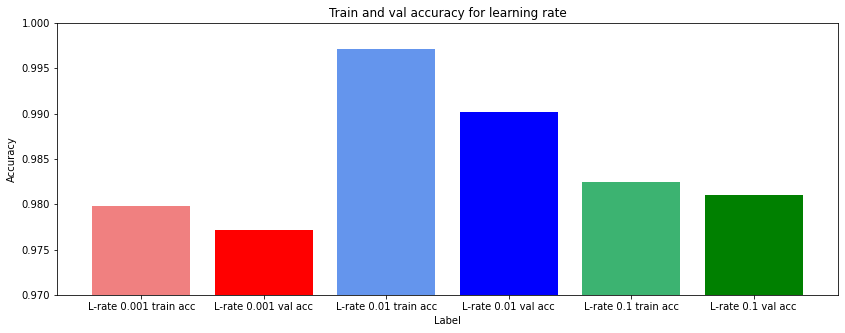

In [63]:
# Histogram
lr_names = list(accuracies_dict.keys())
lr_values = list(accuracies_dict.values())
fig = plt.figure(figsize=(14,5))
plt.ylim(bottom=0.97, top = 1)
plt.bar(lr_names, lr_values, width = 0.8, color=['lightcoral', 'red', 'cornflowerblue', 'blue', 'mediumseagreen', 'green'])
#plt.xticks(np.arange(0, 10))
plt.ylabel('Accuracy')
plt.xlabel('Label')
plt.title("Train and val accuracy for learning rate");

In [64]:
print("Accuracy for optimal learning rate is: %.3f" %accuracies_dict['L-rate 0.01 val acc'])

Accuracy for optimal learning rate is: 0.990


## K-nearest neighbour
The classifier being used is sklearn's KNeiboursClassifier: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html


First we check an initial round of training and validation to see how much time is required. Based on these results we can determine how many hypterparameters it would be feasible to test.

In [ ]:
KNN_clf = KNeighborsClassifier(n_neighbors=3, n_jobs = -1)
start = timeit.default_timer()
KNN_clf.fit(X_train_2d, y_train)
stop = timeit.default_timer()
print("Train runtime for is: %.2f" %(stop-start), "seconds")
start = timeit.default_timer()
val_score2 = KNN_clf.score(X_val_2d, y_val)
stop = timeit.default_timer()
print("Validation runtime  is: %.2f" %(stop-start), "seconds")

It takes about half a minute to train the classifier, and about 5 minutes to get an accuracy score. With k-fold, and k = 3, this would be about 30 (once for train accc and once for train acc) minutes per hyperparameter combination. Since this is quite time consuming, we will only check different values for the "number of neighbours" hyperparameter.

In [ ]:
print('Possible parameters for KNN:')
pprint(KNN_clf.get_params())

In [ ]:
n_neighbours = [5, 9, 15]
KNN_acc_dict = {}

start = timeit.default_timer()
for n in n_neighbours:
    print("Checking no. neighbours = ", n)
    train_acc_per_fold = []
    val_acc_per_fold = []
    KNN_clf = KNeighborsClassifier(n_neighbors= n, n_jobs = -1)
    fold_n = 1
    for train_indices, test_indices in kfold.split(X_train_val_2d, y_train_val):
        print("Fold number", fold_n)
        X_train_set = X_train_val_2d[train_indices]
        y_train_set = y_train_val[train_indices]
        X_test_set = X_train_val_2d[test_indices]
        y_test_set = y_train_val[test_indices]
        KNN_clf.fit(X_train_set, y_train_set)
        train_acc = KNN_clf.score(X_train_set, y_train_set)
        train_acc_per_fold.append(train_acc)
        val_acc = KNN_clf.score(X_test_set, y_test_set)
        val_acc_per_fold.append(val_acc)
        fold_n += 1
    KNN_acc_dict["No. neigh. " + str(n) +' train acc'] = np.mean(train_acc_per_fold)
    KNN_acc_dict["No. neigh. " + str(n) + ' val acc'] = np.mean(val_acc_per_fold)
    
stop = timeit.default_timer()
runtime = ((stop-start) / 60.0)
print("Runtime was: %.2f" %runtime, "minutes")

In [ ]:
# Histogram
KNN_names = list(KNN_acc_dict.keys())
KNN_values = list(KNN_acc_dict.values())
fig = plt.figure(figsize=(14,5))
plt.ylim(bottom=0.95, top = 1)
#plt.bar(names, values)
plt.bar(KNN_names, KNN_values, width = 0.8, color=['lightcoral', 'red', 'cornflowerblue', 'blue', 'mediumseagreen', 'green'])
#plt.xticks(np.arange(0, 10))
plt.ylabel('Accuracy')
plt.xlabel('Label')
plt.title("Train and val accuracy number of neighbours");

In [ ]:
optimal_KNN_score = KNN_acc_dict['No. neigh. 5 val acc']
print("Accuracy for optimal number of neigbours, 15, is: %.3f" %optimal_KNN_score)

Out of the ones tested, the optimal number of neighbours was 5. This may of course not be the true optimal number, and a point of improvement in this project would be to check more values.

## Selection Results

In [22]:
epochs = 10
batch_size = 32
leNet_optimal_model = leNet_5_setup(activation_function = 'tanh', learning_rate = 0.01)
leNet_opt_history = leNet_optimal_model.fit(X_train_4d, y_train_onehot, validation_data=(X_test_4d, y_test_onehot), shuffle=False, batch_size = batch_size, epochs = epochs, verbose = 1) 
train_acc = leNet_opt_history.history['accuracy'][-1]
test_acc = leNet_opt_history.history['val_accuracy'][-1]

Epoch 1/10
1575/1575 [==============================] - 133s 84ms/step - loss: 0.1884 - accuracy: 0.9465 - val_loss: 0.1164 - val_accuracy: 0.9674
Epoch 2/10
1575/1575 [==============================] - 134s 85ms/step - loss: 0.0905 - accuracy: 0.9738 - val_loss: 0.0964 - val_accuracy: 0.9731
Epoch 3/10
1575/1575 [==============================] - 138s 88ms/step - loss: 0.0699 - accuracy: 0.9806 - val_loss: 0.0884 - val_accuracy: 0.9763
Epoch 4/10
1575/1575 [==============================] - 150s 95ms/step - loss: 0.0569 - accuracy: 0.9848 - val_loss: 0.0781 - val_accuracy: 0.9760
Epoch 5/10
1575/1575 [==============================] - 144s 91ms/step - loss: 0.0481 - accuracy: 0.9873 - val_loss: 0.0715 - val_accuracy: 0.9784
Epoch 6/10
1575/1575 [==============================] - 134s 85ms/step - loss: 0.0417 - accuracy: 0.9894 - val_loss: 0.0680 - val_accuracy: 0.9799
Epoch 7/10
1575/1575 [==============================] - 134s 85ms/step - loss: 0.0365 - accuracy: 0.9904 - val_loss: 0

In [23]:
print("Accuracy of LeNet-5 model on new unseen test data:", test_acc)

Accuracy of LeNet-5 model on new unseen test data: 0.9824285507202148


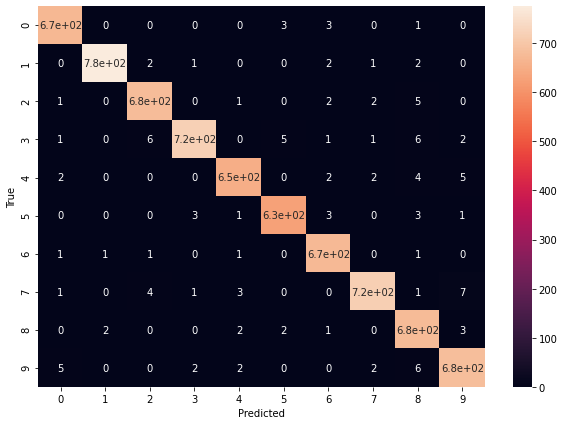

In [61]:
# Preprocess y-values for confusion matrix creation
y_pred = leNet_optimal_model.predict(X_test_4d) # Get predicted values
y_pred = np.argmax(y_pred, axis=1) # Convert arrays to single predicted values
y_true = np.argmax(y_test_onehot, axis=1)

# Generate confusion matrix
confusion_matrix_data = {'True': y_true, 'Predicted': y_pred}
df = pd.DataFrame(confusion_matrix_data, columns=['True','Predicted'])
confusion_matrix_dataframe = pd.crosstab(df['True'], df['Predicted'], rownames=['True'], colnames=['Predicted'])

# Plot confusion matrix
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix_dataframe, annot=True)
plt.show()

As we can see on the confusion matrix, only few digits are misclassified. We can see that our model struggled the most with distingushing 7s from 9s, 8's from 9s and 3s from 8s.